# Regression Modeling Exercises

1. Select a dataset with a continuous target variable.

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from pydataset import data

sns.set_palette('nipy_spectral')

import wrangle as w
import explore as ex
import evaluate as ev

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# First Year GPA
Data is from a dataset called First Year GPA (documentation can be found [here](https://vincentarelbundock.github.io/Rdatasets/doc/Stat2Data/FirstYearGPA.html))

- Target will be to predict first year of collge GPA

### Data Dictionary 
Variable | Description
-- | --
GPA | First-year college GPA on a 0.0 to 4.0 scale
HSGPA |High school GPA on a 0.0 to 4.0 scale
SATV	|Verbal/critical reading SAT score
SATM	|Math SAT score
Male	|1= male, 0= female
HU	|Number of credit hours earned in humanities courses in high school
SS	|Number of credit hours earned in social science courses in high school
FirstGen	|1= student is the first in her or his family to attend college, 0=otherwise
White	|1= white students, 0= others
CollegeBound	|1=attended a high school where >=50% students intended to go on to college, 0=otherwise


In [2]:
sns.color_palette('viridis')

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

In [3]:
sns.color_palette()

[(0.0941117647058824, 0.0, 0.6549294117647059),
 (0.0, 0.5634078431372549, 0.8667),
 (0.0, 0.6300803921568627, 0.24050784313725487),
 (0.0, 0.9268156862745098, 0.0),
 (0.9516098039215687, 0.8967078431372549, 0.0),
 (0.9764764705882353, 0.0, 0.0)]

In [4]:
# read dataset into dataframe
df = pd.read_csv('FirstYearGPA.csv')

In [5]:
# Take a peak at the data
# looks like the first column is a student number (probably can drop it and just use the index)
df.head()

,Unnamed: 0,GPA,HSGPA,SATV,SATM,Male,HU,SS,FirstGen,White,CollegeBound
0,1,3.06,3.83,680,770,1,3.0,9.0,1,1,1
1,2,4.15,4.00,740,720,0,9.0,3.0,0,1,1
2,3,3.41,3.70,640,570,0,16.0,13.0,0,0,1
3,4,3.21,3.51,740,700,0,22.0,0.0,0,1,1
4,5,3.48,3.83,610,610,0,30.5,1.5,0,1,1


In [6]:
# all of the data appears to be numbers should be able to plot pretty easily
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    219 non-null    int64  
 1   GPA           219 non-null    float64
 2   HSGPA         219 non-null    float64
 3   SATV          219 non-null    int64  
 4   SATM          219 non-null    int64  
 5   Male          219 non-null    int64  
 6   HU            219 non-null    float64
 7   SS            219 non-null    float64
 8   FirstGen      219 non-null    int64  
 9   White         219 non-null    int64  
 10  CollegeBound  219 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 18.9 KB


In [7]:
# doesn't look like there's any nulls
# maybe rename the columns so i don't have to type in capitals? maybe too much work
df.isnull().any()

Unnamed: 0      False
GPA             False
HSGPA           False
SATV            False
SATM            False
Male            False
HU              False
SS              False
FirstGen        False
White           False
CollegeBound    False
dtype: bool

In [8]:
df.White.value_counts()

1    173
0     46
Name: White, dtype: int64

In [9]:
df.FirstGen.value_counts()

0    194
1     25
Name: FirstGen, dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,219.0,110.000000,63.364028,1.00,55.500,110.00,164.50,219.00
GPA,219.0,3.096164,0.465476,1.93,2.745,3.15,3.48,4.15
HSGPA,219.0,3.452740,0.374794,2.34,3.170,3.50,3.76,4.00
SATV,219.0,605.068493,83.393452,260.00,565.000,610.00,670.00,740.00
SATM,219.0,634.292237,75.235572,430.00,580.000,640.00,690.00,800.00
Male,219.0,0.465753,0.499969,0.00,0.000,0.00,1.00,1.00
HU,219.0,13.108219,7.224647,0.00,8.000,13.00,17.00,40.00
SS,219.0,7.248858,5.000315,0.00,3.000,6.00,11.00,21.00
FirstGen,219.0,0.114155,0.318728,0.00,0.000,0.00,0.00,1.00
White,219.0,0.789954,0.408274,0.00,1.000,1.00,1.00,1.00


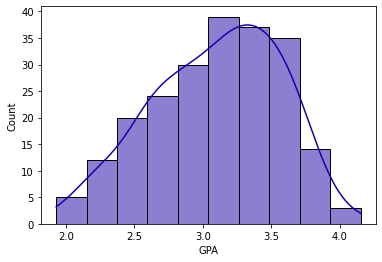

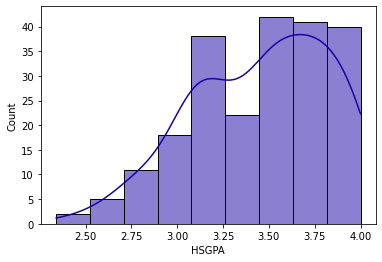

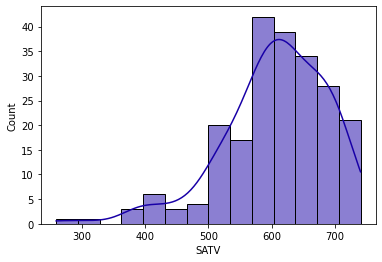

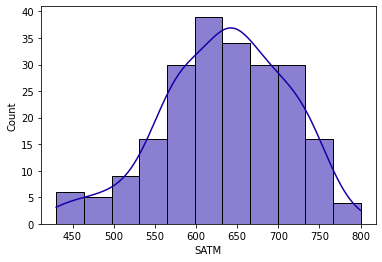

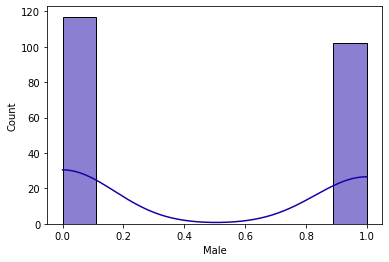

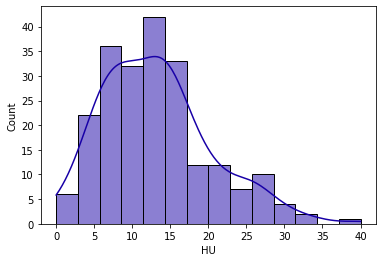

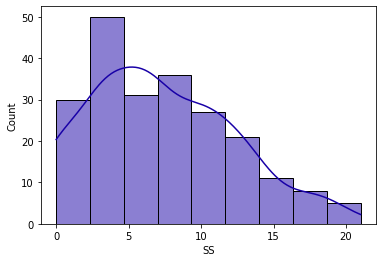

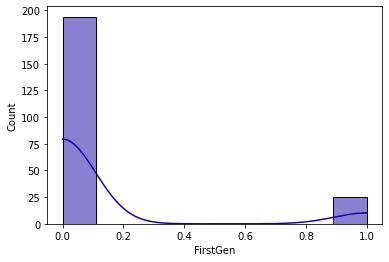

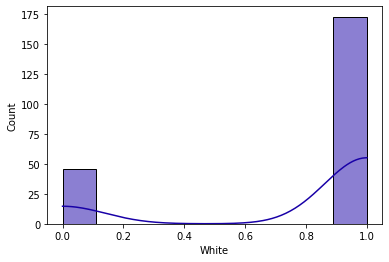

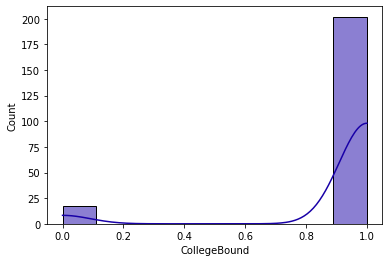

In [12]:
# univariate plotting to see distribution
#df.drop(columns=['Unnamed: 0']).columns
for col in list(df):
    sns.histplot(data = df, x = col, kde=True)
    plt.show()

### Takeaways
- Male, first gen, college bound are binomially distributed (1 or the other, categorical variables)
- Target (GPA) is normally distributed
- SATM is normally distributed
- SATV and HSGPA have a left tail
- SS and HU have a right tail 

## Split data and Explore (a bit)

In [14]:
# drop Unnamed column first
df.drop(columns='Unnamed: 0', inplace=True)

In [15]:
train, validate, test = w.banana_split(df)

train --> (122, 10)
validate --> (53, 10)
test --> (44, 10)


In [16]:
target = 'GPA'
cat_vars = ['Male', 'FirstGen', 'White', 'CollegeBound']
cont_vars = list(train.drop(columns=cat_vars).columns)

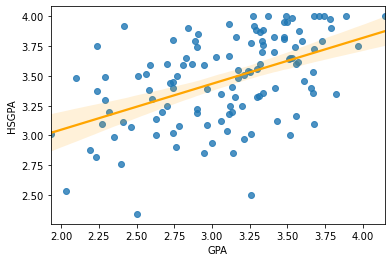

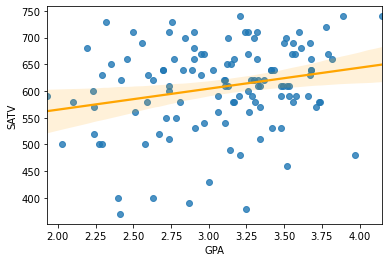

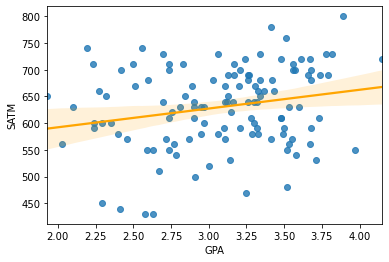

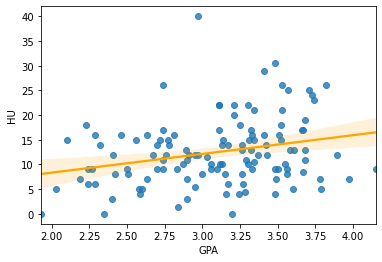

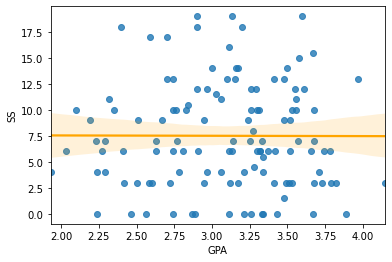

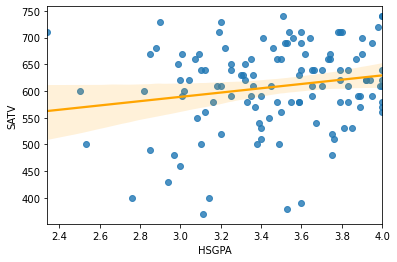

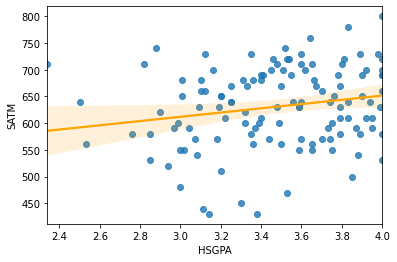

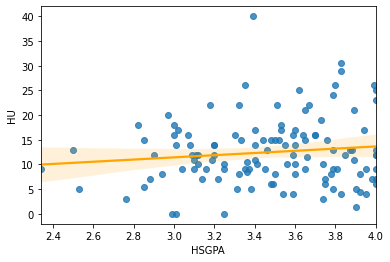

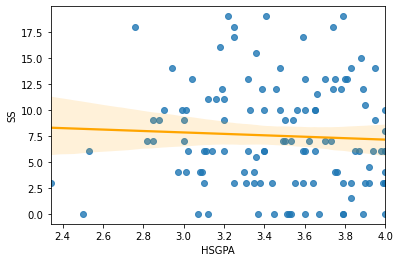

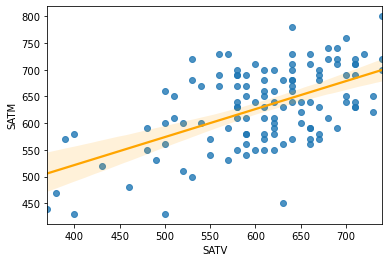

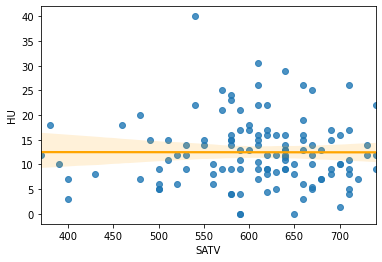

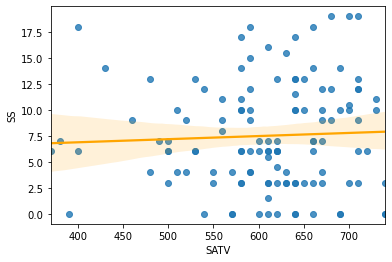

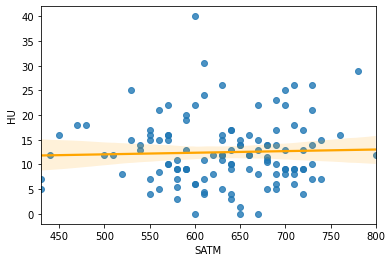

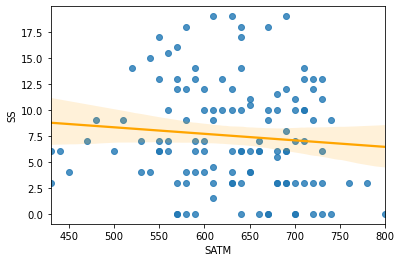

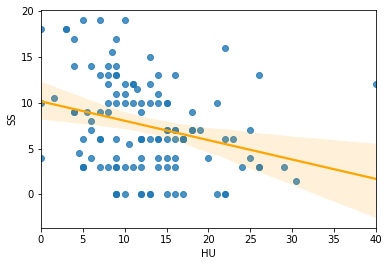

In [17]:
ex.plot_variable_pairs(train, cont_vars)

In [18]:
# scale data using my function
mm_scaler, scaled_cols = w.my_scaler(train, validate, test, list(train.columns), MinMaxScaler(), 'mm')

Your scaled columns have been added to your train validate and test dataframes.


In [19]:
# make a seperate dataframe for it
train_scaled = train[scaled_cols]

In [20]:
# look at scaled dataframe 
train_scaled.head()

,GPA_mm,HSGPA_mm,SATV_mm,SATM_mm,Male_mm,HU_mm,SS_mm,FirstGen_mm,White_mm,CollegeBound_mm
199,0.373874,0.337349,0.972973,0.513514,1.0,0.30,0.526316,0.0,1.0,1.0
28,0.572072,0.548193,0.594595,0.648649,0.0,0.00,0.947368,0.0,1.0,1.0
112,0.333333,0.518072,0.405405,0.216216,0.0,0.30,0.473684,0.0,0.0,1.0
188,0.216216,0.463855,0.000000,0.027027,0.0,0.30,0.315789,1.0,0.0,1.0
87,0.603604,1.000000,0.513514,0.702703,0.0,0.15,0.421053,1.0,1.0,1.0


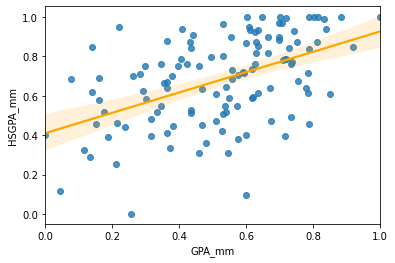

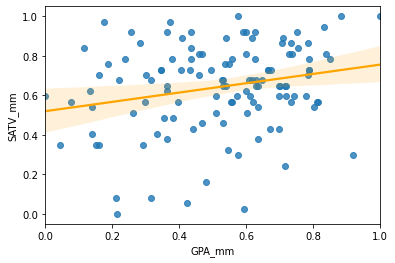

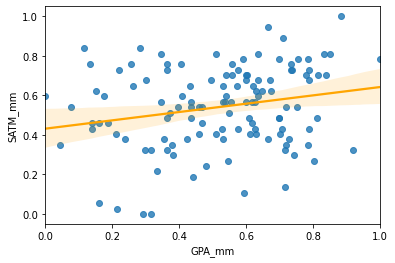

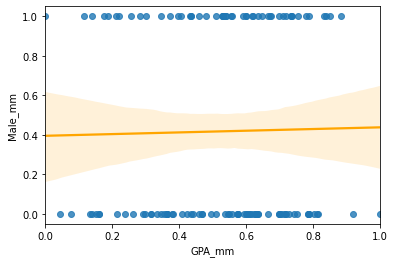

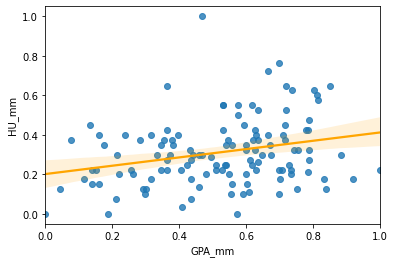

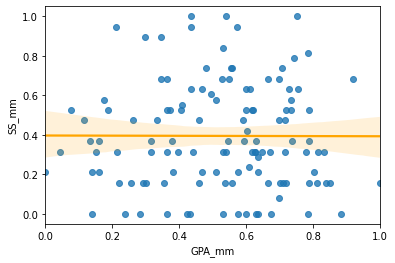

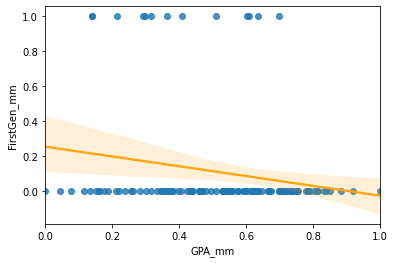

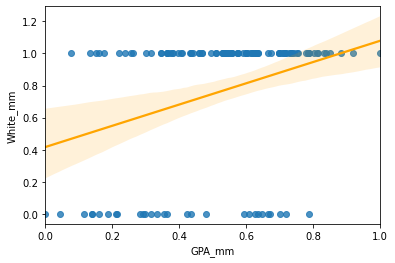

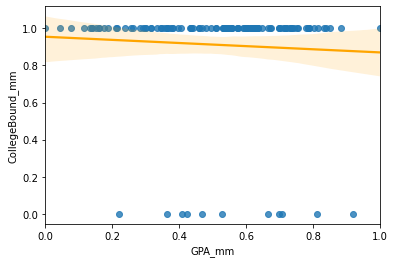

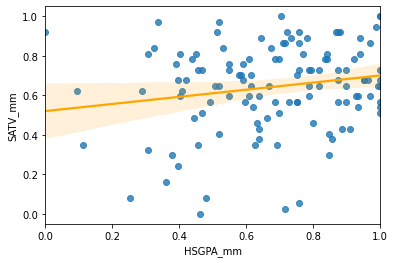

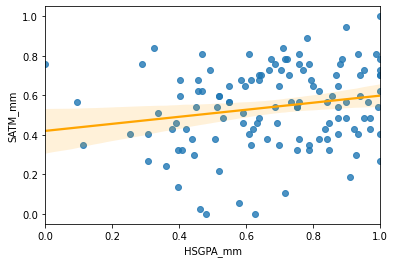

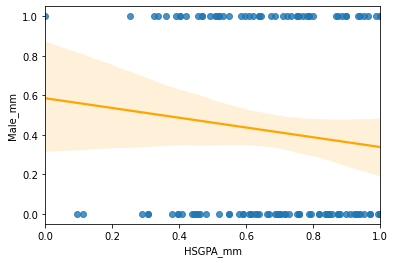

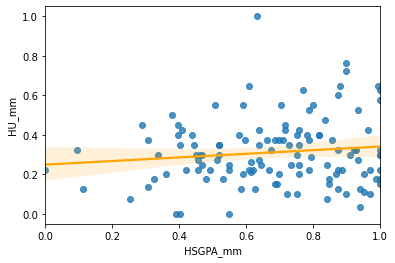

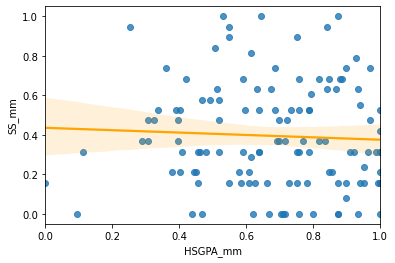

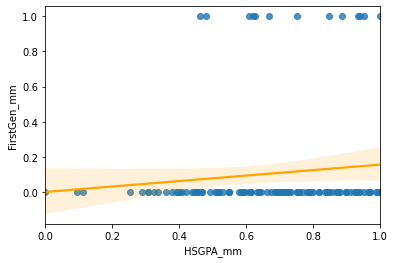

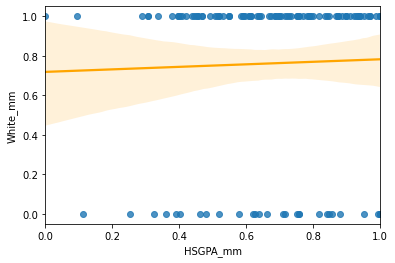

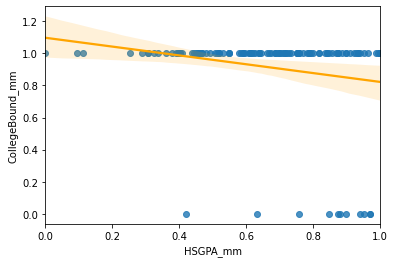

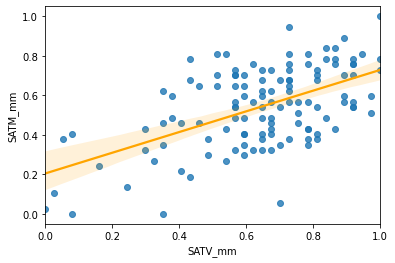

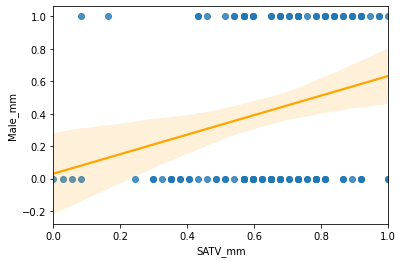

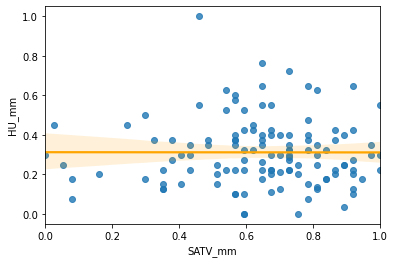

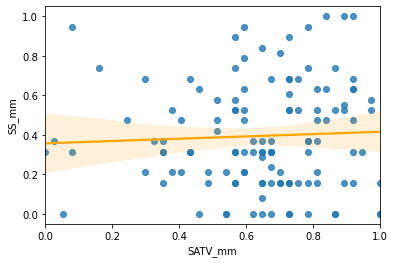

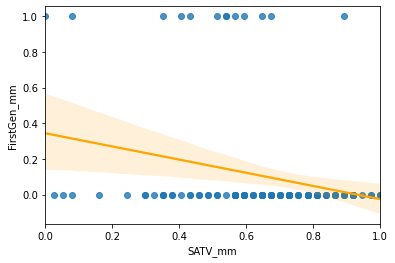

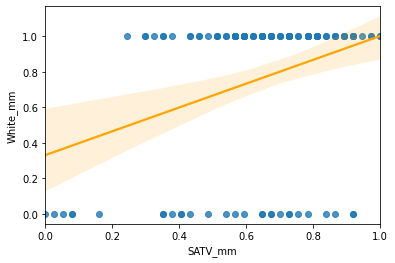

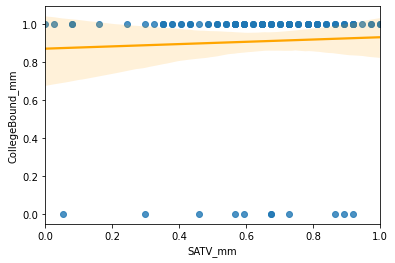

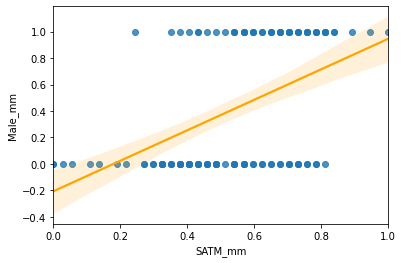

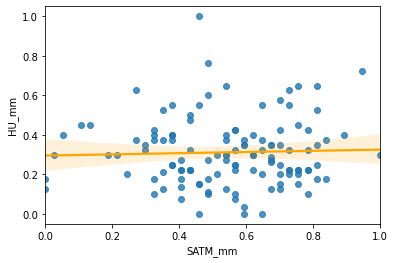

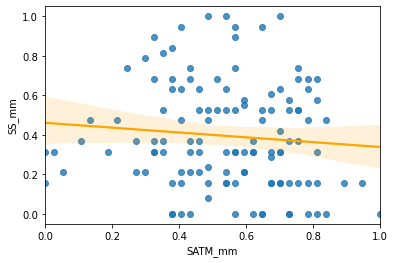

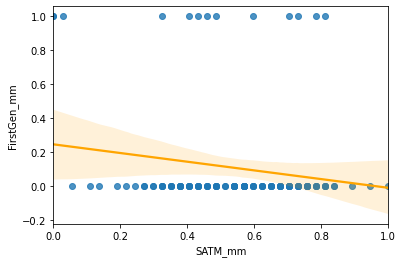

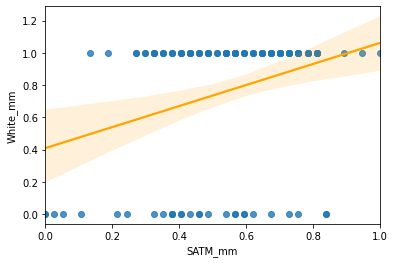

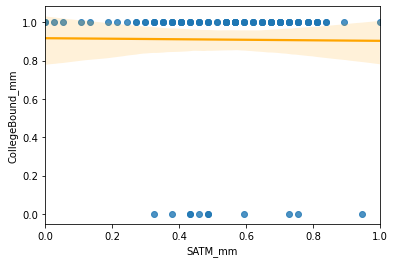

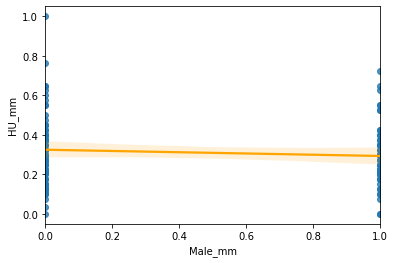

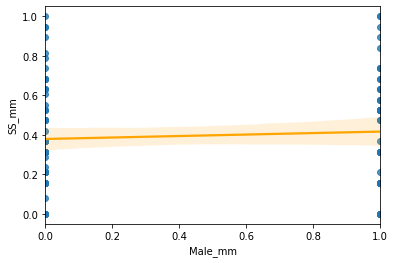

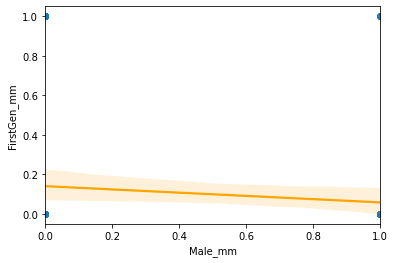

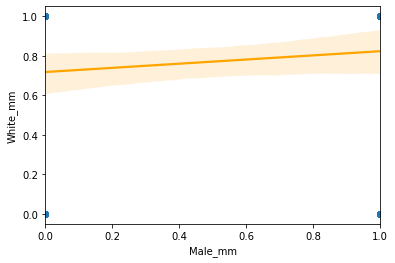

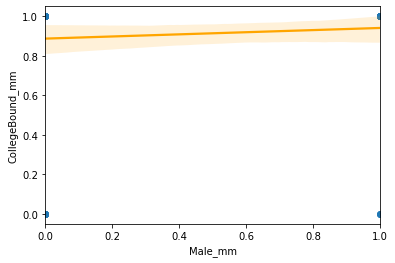

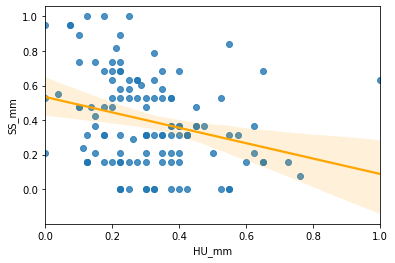

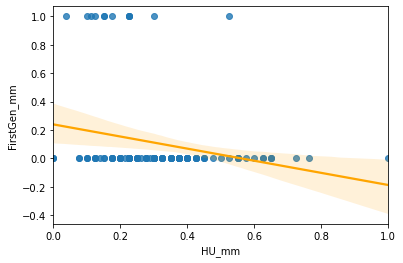

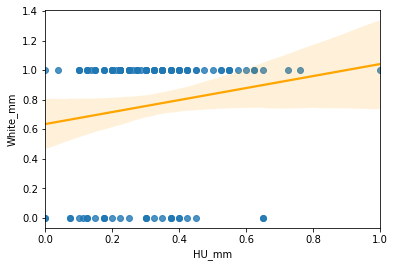

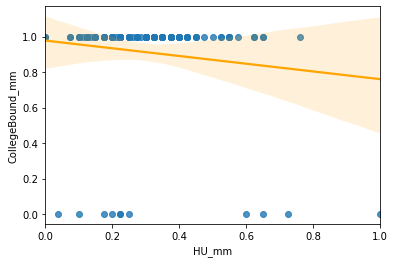

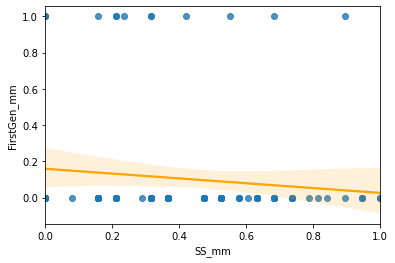

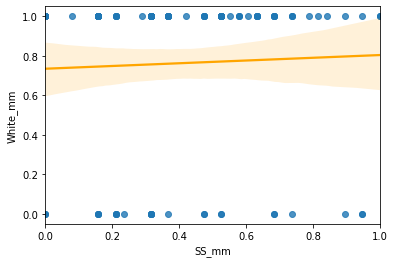

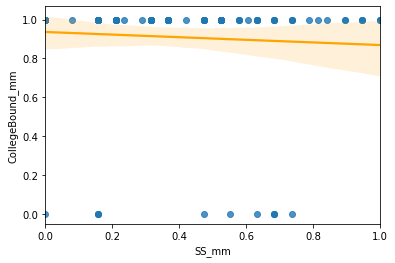

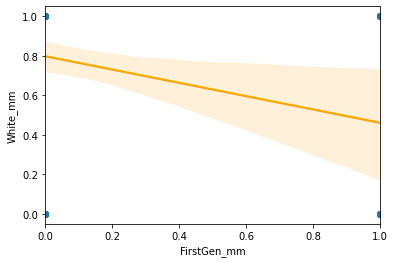

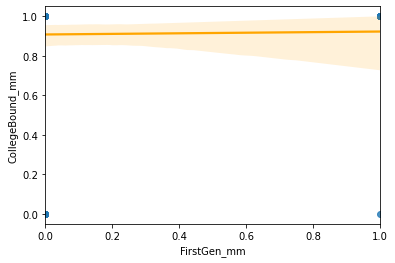

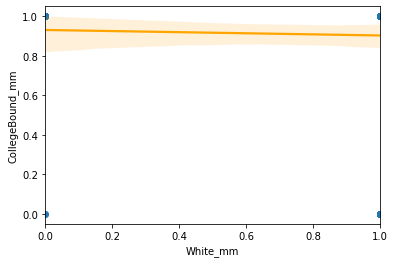

In [21]:
ex.plot_variable_pairs(train_scaled, scaled_cols)

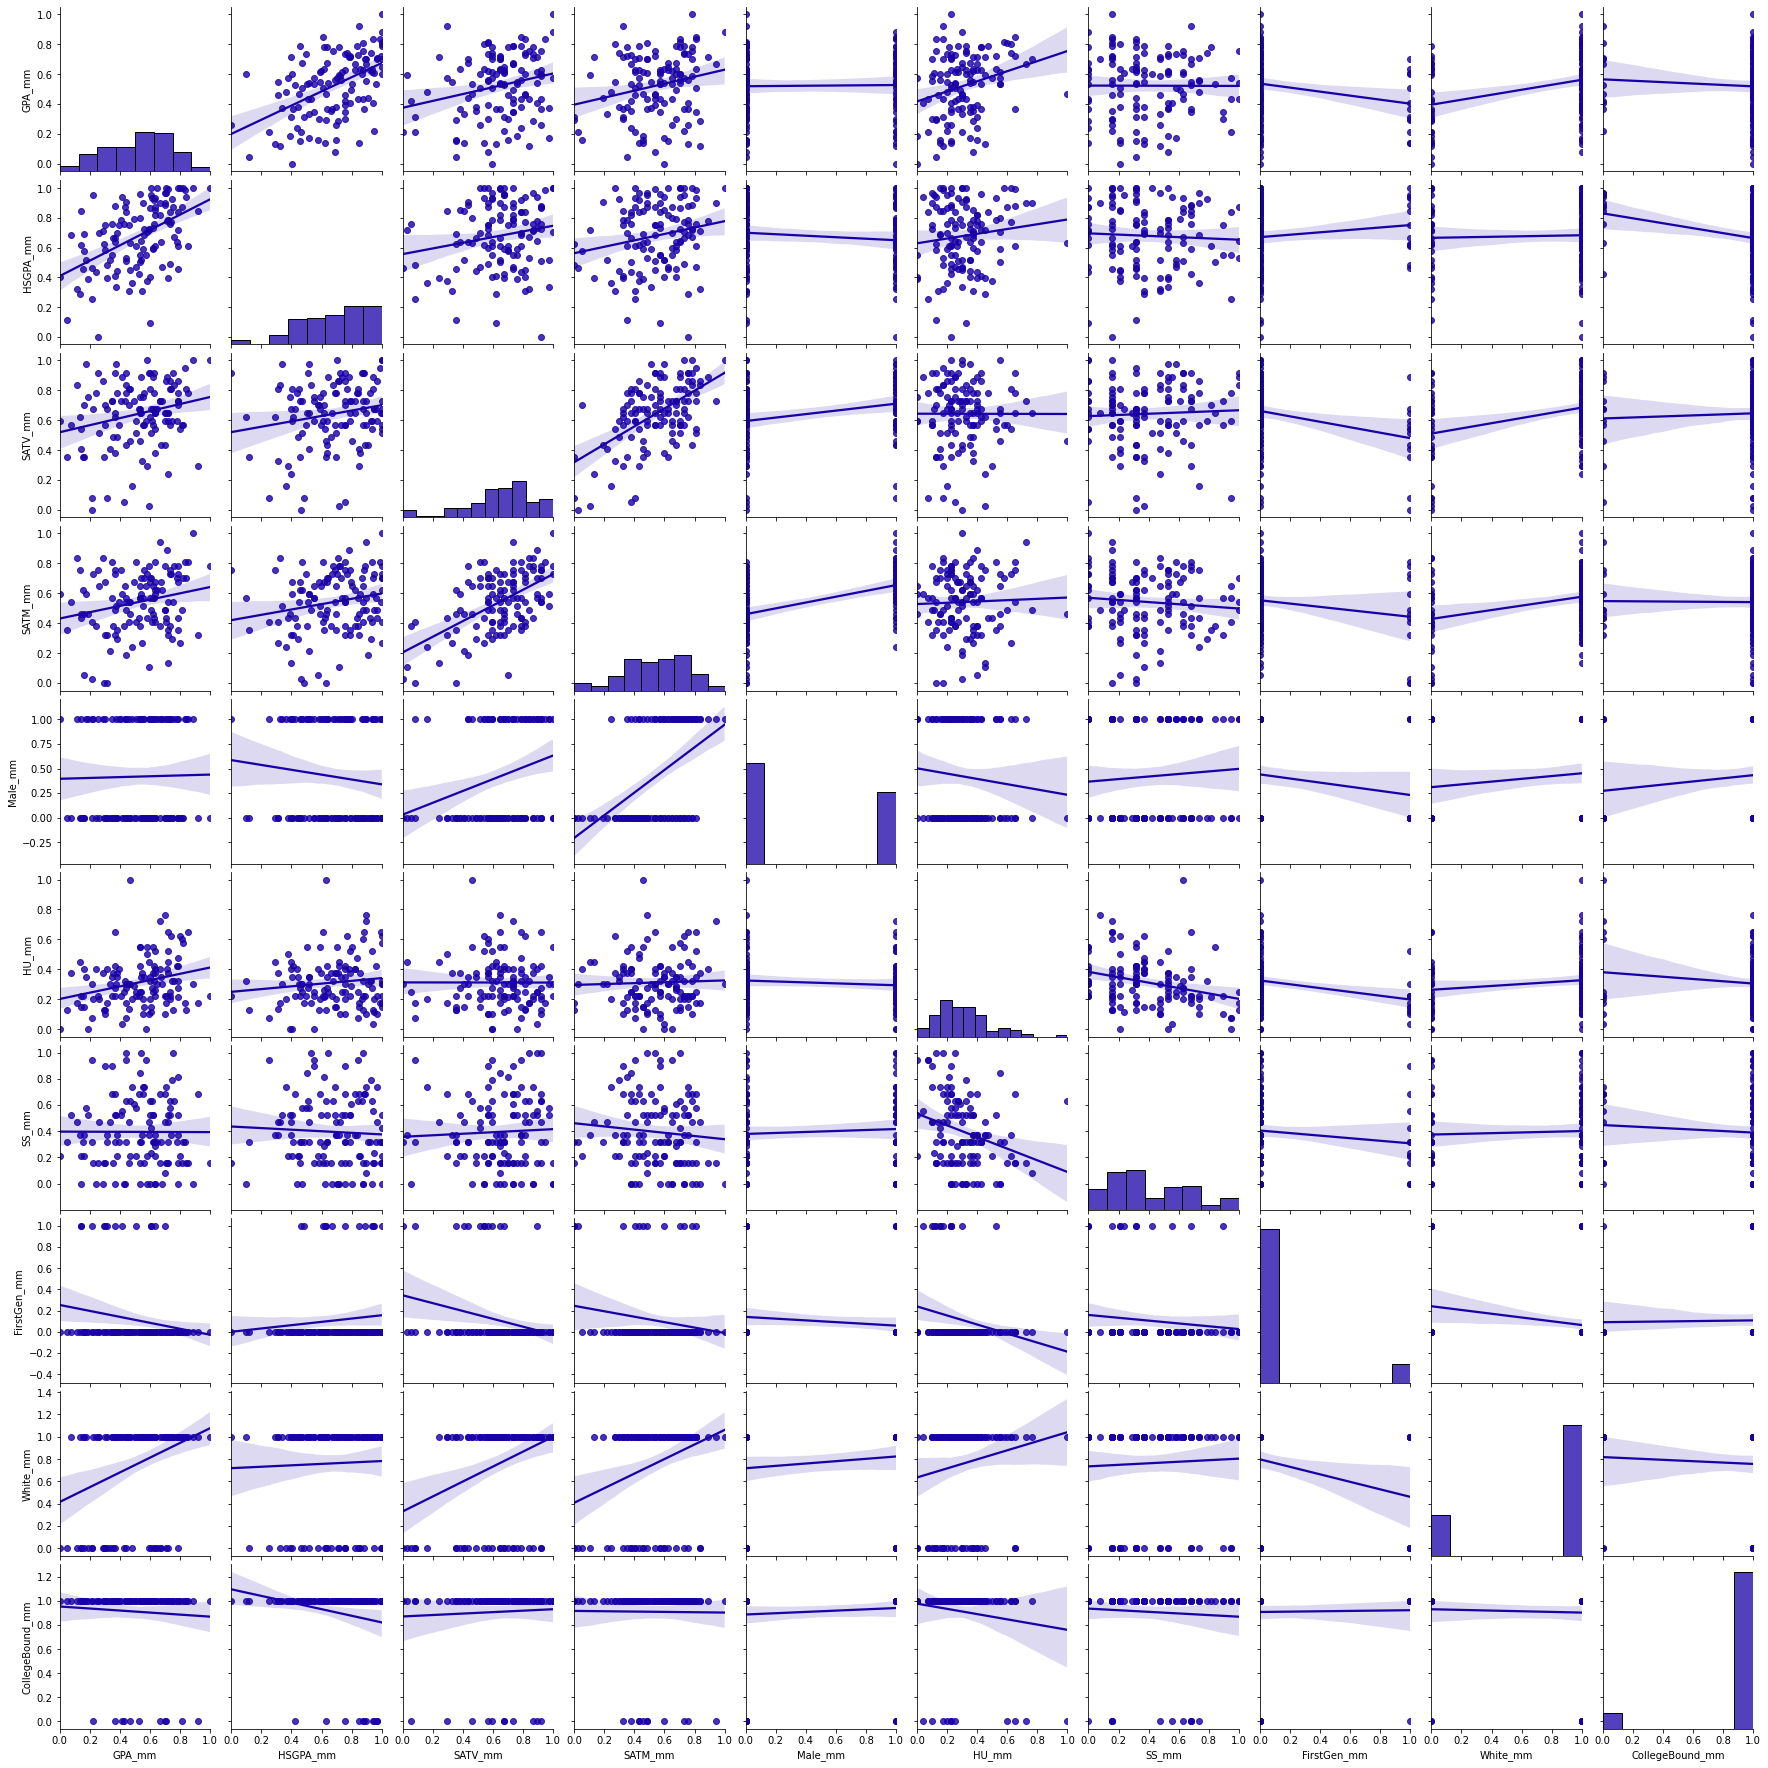

In [103]:
sns.pairplot(train_scaled, kind = 'reg')

### Takeaways
- biggest correlations seem to be High school gpa, SAT scores
- Don't think there's enough data for White, CollegBound, and FirstGen to really use. too small of a pool 

<AxesSubplot:>

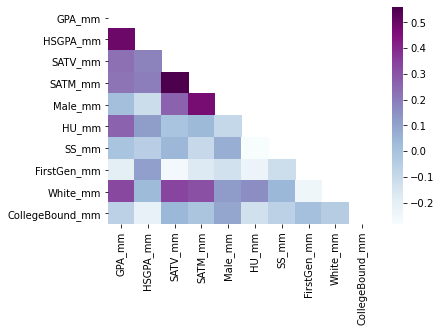

In [22]:
sns.heatmap(train_scaled.corr(), cmap='BuPu', mask = np.triu(train_scaled.corr()))

## Feature Selection
- Decided to take out these columns 'White_mm', 'FirstGen_mm', 'CollegeBound_mm'
- there wasn't a lot of data there 

In [ ]:
# if you need to re run feature selection start here

In [23]:
# Set X and y (taking out White and FirstGen and CollegeBound )
y_train = train.GPA
X_train = train[scaled_cols].drop(columns= ['GPA_mm', 'White_mm', 'FirstGen_mm', 'CollegeBound_mm'])

In [24]:
# Set X and y for validate
y_validate = validate.GPA
X_validate = validate[scaled_cols].drop(columns= 'GPA_mm')

# Set X and y for test
y_test = test.GPA
X_test = test[scaled_cols].drop(columns= 'GPA_mm')

In [25]:
ev.select_kbest(X_train, y_train, 4)

['HSGPA_mm', 'SATV_mm', 'SATM_mm', 'HU_mm']

In [26]:
# Use these 
ev.rfe(X_train, y_train, 3)

['HSGPA_mm', 'SATV_mm', 'HU_mm']

In [27]:
feat_list = ev.rfe(X_train, y_train, 3)

## Modeling
For a normally distributed y and a linear relationship: OLS, LassoLars, GLM(power=0) will work best.

#### ToDo
 - Make Baseline (median and mean and pick best)
 - model OLS, LassoLars, GLM(power=0)
 - visualize results

In [28]:
sse, mse, rmse = ev.baseline_mean_errors(y_train)
sse, mse, rmse 

(27.427796721311477, 0.22481800591238915, 0.4741497716042782)

In [29]:
X_train['baseline_mean'] = y_train.mean()
X_validate['baseline_mean'] = y_train.mean()

In [30]:
X_train['baseline_median'] = y_train.median()
X_validate['baseline_median'] = y_train.median()

In [31]:
rmse_train = mean_squared_error(y_train, X_train.baseline_mean, squared=False)
rmse_validate = mean_squared_error(y_validate, X_validate.baseline_mean, squared=False)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

rmse_train = rmse_train = mean_squared_error(y_train, X_train.baseline_median, squared=False)
rmse_validate = mean_squared_error(y_validate, X_validate.baseline_median, squared=False)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.47 
Validate/Out-of-Sample:  0.46
RMSE using Median
Train/In-Sample:  0.48 
Validate/Out-of-Sample:  0.47


#### These are both equally terrible. I'm going to use the Mean for the baseline

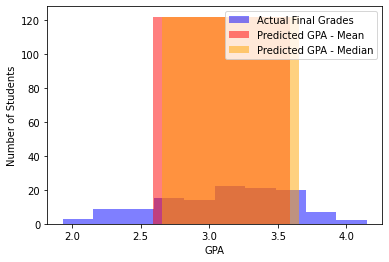

In [32]:
# plot to visualize actual vs predicted. 
plt.hist(y_train, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(X_train.baseline_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted GPA - Mean")
plt.hist(X_train.baseline_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted GPA - Median")
plt.xlabel("GPA")
plt.ylabel("Number of Students")
plt.legend()
plt.show()

In [33]:
# reset Xtrain with the scaled data that I want to use from feature selection

X_train2 = X_train[feat_list]
X_validate2 = X_validate[feat_list]
X_test2 = X_test[feat_list]

#### Start with OLM

In [34]:
# Fit OLM model
lm = LinearRegression()

lm.fit(X_train2, y_train)

X_train['model1_pred'] = lm.predict(X_train2)

rmse_train = mean_squared_error(y_train, X_train.model1_pred, squared = False)

X_validate['model1_pred'] = lm.predict(X_validate2)

rmse_validate = mean_squared_error(y_validate, X_validate.model1_pred, squared=False) 

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.39389932800514754 
Validation/Out-of-Sample:  0.3493433745809635


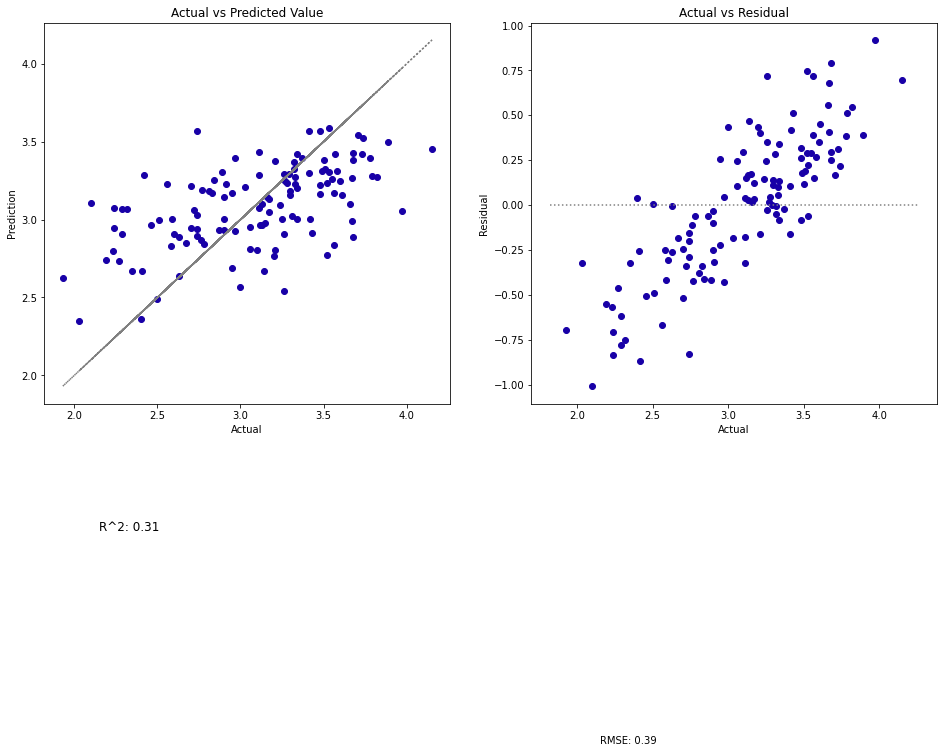

In [35]:
ev.plot_the_dots(y_train, X_train.model1_pred, y_train - X_train.model1_pred)

In [36]:
# model LassoLars

lars = LassoLars(alpha = 1.0)

lars.fit(X_train2, y_train)

X_train['model2_pred'] = lars.predict(X_train2)

rmse_train = mean_squared_error(y_train, X_train.model2_pred, squared = False)

X_validate['model2_pred'] = lars.predict(X_validate2)

rmse_validate = mean_squared_error(y_validate, X_validate.model2_pred, squared=False)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.4741497716042782 
Validation/Out-of-Sample:  0.46472951163777515


#### The Lasso Lars one did worse than the OLM

In [37]:
# model Tweedie Regressor GLM

glm = TweedieRegressor(alpha=1.0, power=0.0)

glm.fit(X_train2, y_train)

X_train['model3_pred'] = glm.predict(X_train2)

rmse_train = mean_squared_error(y_train, X_train.model3_pred, squared=False)

X_validate['model3_pred'] = glm.predict(X_validate2)

rmse_validate = mean_squared_error(y_validate, X_validate.model3_pred, squared=False)

print("RMSE for GLM\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM
Training/In-Sample:  0.4667813019641524 
Validation/Out-of-Sample:  0.45454285167022934


#### Did not see much improvement with the GLM. OLS Model did the best out of the three

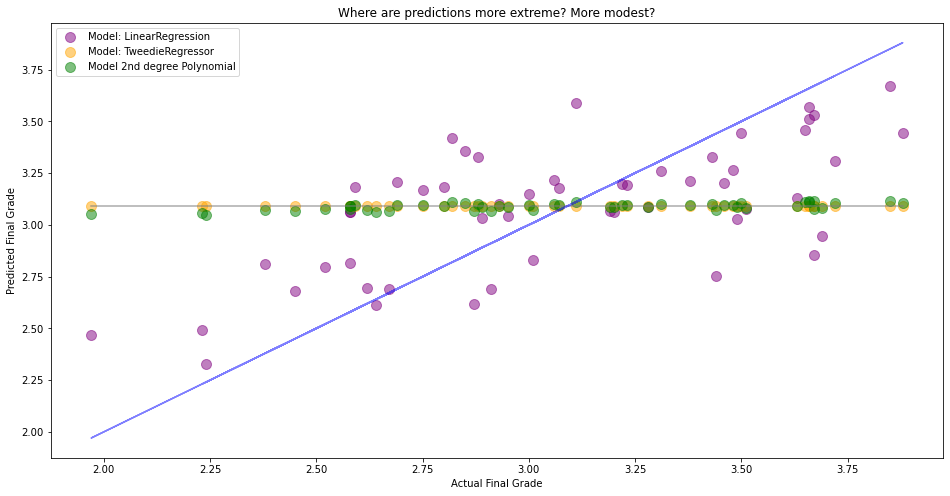

In [51]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate, X_validate.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
#plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate, y_validate, alpha=.5, color="blue", label='_nolegend_')
#plt.annotate("The Ideal Line: Predicted = Actual", (1,1)rotation=15.5)

plt.scatter(y_validate, X_validate.model1_pred, 
            alpha=.5, color="purple", s=100, label="Model: LinearRegression")
plt.scatter(y_validate, X_validate.model2_pred, 
            alpha=.5, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate, X_validate.model3_pred, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [43]:
# more testing with OLM 

feat_list_2 = ev.rfe(X_train, y_train, 2)
feat_list_4 = ev.rfe(X_train, y_train, 4)

list_of_lists = [feat_list_2, feat_list_4]

In [46]:
model_num = 2

for features in list_of_lists:
    
    X_train3 = X_train[features]
    
    X_validate3 = X_validate[features]
    
    lm = LinearRegression()
    
    lm.fit(X_train3, y_train)
    
    X_train[f'OLM{model_num}_pred'] = lm.predict(X_train3)
    
    rmse_train = mean_squared_error(y_train, X_train[f'OLM{model_num}_pred'], squared = False)
    
    X_validate[f'OLM{model_num}_pred'] = lm.predict(X_validate3)
    
    rmse_validate = mean_squared_error(y_validate, X_validate[f'OLM{model_num}_pred'], squared=False) 
    
    print(f"RMSE for OLS model{model_num} using LinearRegression\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)
    print('--------------------------------------------------')
    
    model_num += 1

RMSE for OLS model2 using LinearRegression
Training/In-Sample:  0.3938993280051476 
Validation/Out-of-Sample:  0.34934337458096354
--------------------------------------------------
RMSE for OLS model3 using LinearRegression
Training/In-Sample:  0.40569914428589615 
Validation/Out-of-Sample:  0.37422751914923463
--------------------------------------------------


### Testing OLM with different numbers of features 
- Looking for close and low. No apparent improvement changing the features
- Difference between 2 and 3 features doesn't seem to be that different
- try with 1 

In [47]:
   
    
X_train3 = X_train[['HSGPA_mm']]

X_validate3 = X_validate[['HSGPA_mm']]

lm = LinearRegression()

lm.fit(X_train3, y_train)

X_train['OLM_1_feat_pred'] = lm.predict(X_train3)

rmse_train = mean_squared_error(y_train, X_train['OLM_1_feat_pred'], squared = False)

X_validate['OLM_1_feat_pred'] = lm.predict(X_validate3)

rmse_validate = mean_squared_error(y_validate, X_validate['OLM_1_feat_pred'], squared=False) 

print(f"RMSE for OLM_1_feat_pred using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLM_1_feat_pred using LinearRegression
Training/In-Sample:  0.41208722789249064 
Validation/Out-of-Sample:  0.41417461102672515


- two features is best. 1 feature is not as good. 3 features is similar to 2 features.

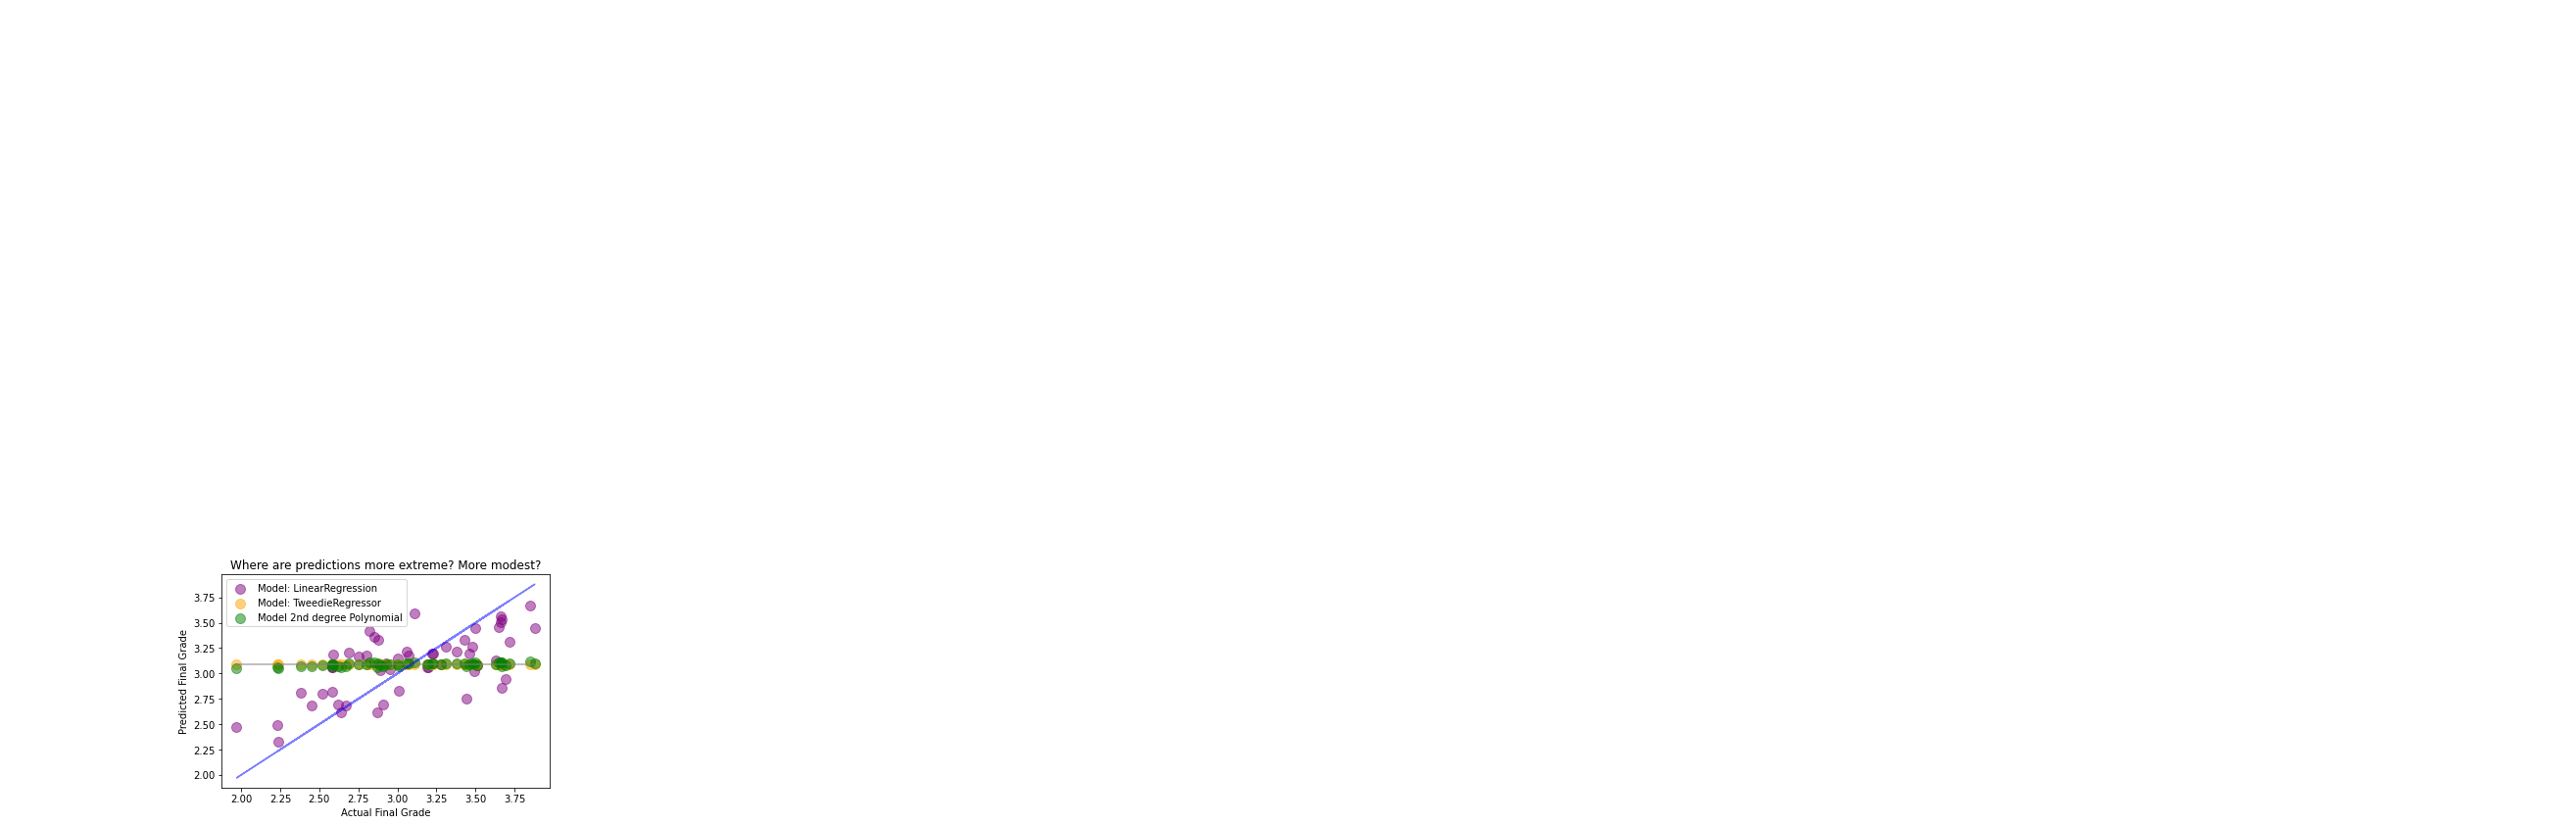

In [42]:
# y_validate.head()
#plt.figure(figsize=(16,8))
plt.plot(y_validate, X_validate.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate, y_validate, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate, X_validate.model1_pred, 
            alpha=.5, color="purple", s=100, label="Model: LinearRegression")
plt.scatter(y_validate, X_validate.model2_pred, 
            alpha=.5, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate, X_validate.model3_pred, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()